# Bayesian Parameter Estimation
This notebook will use the methodology of Bayesian parameter estimation to help estimate paramters for some models of the background data. This uses the formalism taught in the Inference From Scientific Data module taught by Dr Christopher J. Moore.

Essentially for each of our models $M_i(\theta)=M(m_i;\theta)$ we define Bayes' problem as $P(M|D)=\frac{1}{Z}P(D|M)P(M)$. Where $\theta$ are a set of unknown parameters.

In [1]:
import numpy as np
from scipy.stats import poisson 
import matplotlib.pyplot as plt
import pandas as pd

## Define Models
Usually we would define our models in here. However, since we are using mutliple different methods to do our parameter estimation the models are actually defined in the BgFuncs module where full documentation is available, so instead we just import that.

In [2]:
import sys
sys.path.append('../')
import BgFuncs as bf

## Load Data
We have already read in the masses before and binned the data then removed blinded region data and cut on a particular mass region. This all takes significant time, instead of doing it again just read in the cleaned data using Pandas.

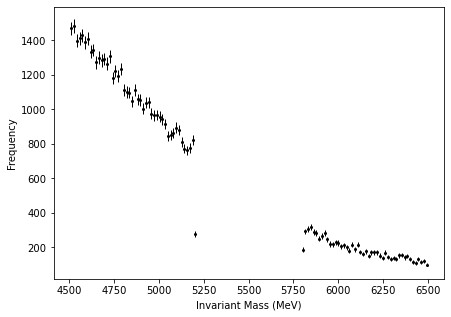

In [3]:
d = pd.read_csv('/home/user211/project/data/200bins_rmblind_masses.txt')
x, y, yerr = d['Mass'].to_numpy(), d['Frequency'].to_numpy(), d['Error'].to_numpy()

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.errorbar(x, y, yerr=yerr, fmt="o", ms=2, capsize=0, elinewidth=1, color='k')
ax.set_xlabel('Invariant Mass (MeV)')
ax.set_ylabel('Frequency')
plt.show()

As you can see from the data in the above plot, there are two rogue data points which are due to how the bins were cut off when straddling the blinded region. We will remove these points manually now. We can only do this becasue we know the source of the problem and it is not actually physical.

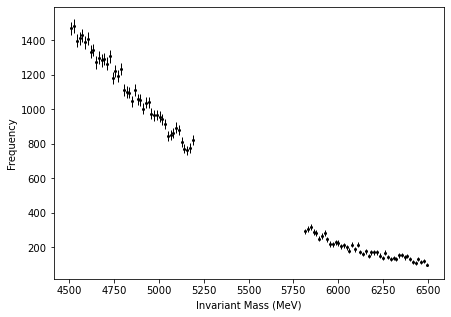

In [4]:
x, y, yerr = np.concatenate((x[0:45], x[47:])), np.concatenate((y[0:45], y[47:])), np.concatenate((yerr[0:45], yerr[47:]))
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.errorbar(x, y, yerr=yerr, fmt="o", ms=2, capsize=0, elinewidth=1, color='k')
ax.set_xlabel('Invariant Mass (MeV)')
ax.set_ylabel('Frequency')
plt.show()

## Bayesian Analysis Begins
To start we will use the basic exponential function of the form $M(m; A,k,b,c)=Ae^{-(km-b)}+c$. And we use a poission distribution for our likelihood.

In [5]:
def log_likelihood(k, b, c, f=x, d=y):
    """
    P(data | A, k, b, c)
    """
    m = bf.polynomial(f, k, b, c)
    return np.sum([poisson(m[i]).logppmf(d[i]) for i in range(len(f))])

def log_likelihood_fast(k, b, c, f=x, d=y):
    """
    An ultrafast implementation of log_likelihood
    """
    m = bf.polynomial(f, k, b, c)
    return np.sum(poisson(m).logpmf(d))

In [6]:
def log_prior(k, b, c, kmax=100, kmin=1, bmax=100, bmin=1, cmax=100, cmin=1):
    """
    P(A, k, b, c)
    """ 
    #this is a Jeffreys prior might be better to use a uniform one for now
    k_log_prior = -np.log(k) - np.log(np.log(kmax/kmin))
    b_log_prior = -np.log(b) - np.log(np.log(bmax/bmin))
    c_log_prior = -np.log(c) - np.log(np.log(cmax/cmin))
    return b_log_prior + k_log_prior + c_log_prior

In [7]:
def log_posterior(k, b, c, f=x, d=y):
    """
    P(A,k,b,c | data) not normalised
    """
    return (log_likelihood_fast(k, b, c, f, d) + log_prior(k, b, c))

## Find Modal Parameters
Now we find the model parameters using the posterior and priors defined above.

In [11]:
from scipy.optimize import minimize

x0 = (2e-4, -1, 6000)
sol = minimize(lambda x: -log_posterior(x[0], x[1], x[2]), x0)
sol

/tmp/ipykernel_3381502/1440415052.py:7: RuntimeWarning: invalid value encountered in log
  b_log_prior = -np.log(b) - np.log(np.log(bmax/bmin))


      fun: nan
 hess_inv: array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1]])
      jac: array([nan, nan, nan])
  message: 'NaN result encountered.'
     nfev: 4
      nit: 0
     njev: 1
   status: 3
  success: False
        x: array([ 2.e-04, -1.e+00,  6.e+03])

In [12]:
k_hat = sol.x[0]
b_hat = sol.x[1]
c_hat = sol.x[2]

max_post = log_posterior(k_hat, b_hat, c_hat)

/tmp/ipykernel_3381502/1440415052.py:7: RuntimeWarning: invalid value encountered in log
  b_log_prior = -np.log(b) - np.log(np.log(bmax/bmin))


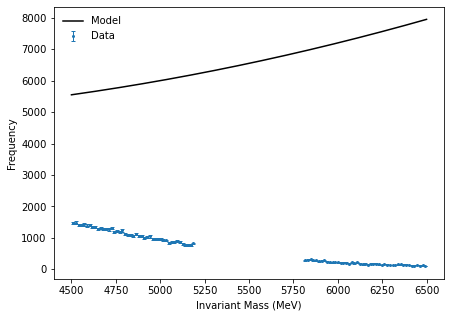

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
f_grid = np.linspace(4500, 6500, 1000)
ax.errorbar(x, y, yerr=yerr, fmt="o", ms=2, capsize=2, elinewidth=1, label='Data')
ax.plot(f_grid, bf.polynomial(f_grid, k_hat, b_hat, c_hat), 'k-', label='Model')
ax.set_xlabel('Invariant Mass (MeV)')
ax.set_ylabel('Frequency')
plt.legend(frameon=False)
plt.show()